<center style='font-size:28px;'><u><b>Retail</b></u></center>

1. [Project Description](#start)
    * [Data Description](#dd)
2. [Pre-Processing](#pp)
    * [Reading Files](#refa)
    * [`product_codes`](#pppc)
    * [`retail`](#ppre)
        * [`retail`'s missing values](#rmv)
    * [merging `retail` and `product_codes`](#mrap)
    * [`retail`'s duplicates](#rdv)
    * [Outliers Removal](#outrem)
    * [Pre-Processing Summation](#ppsu)
3. [EDA](#eda)
    * [EDA Summation](#edas)
4. [Plan for The Project](#pftp)
5. [Active Users](#acus)
    * [MAU](#mau)
    * [WAU](#wau)
    * [DAU](#dau)
    * [DAU/MAU Ratio](#dmr)
5. [Cohort Analysis](#cohana)
    * [Retention](#reten)
    * [Churn](#churn)
    * [Average Purchase Size](#avprsz)
    * [Revenue per Customer](#revprcs)
    * [Cohort Analysis Summation](#cohanasum)
6. [Leading Shops](#leadshops)
    * [Revenue per Customer](#rvprcr)
    * [Average Purchase](#avgprch)
    * [Number of Customers](#nofcust)
    * [Purchases per Customer](#prcprcstm)
    * [Leading Shops Summation](#leadshopsum)
7. [Characterising Loyal Customers](#clc)
    * [Purchases per Customer](#prchprcs)
    * [Number of Shops Visited](#nmbsv)
    * [Items per Purchase](#itpp)
    * [Price per Purchase](#prprpr)
    * [Loyal Characterisation Summation](#lychsum)
8. [Hypotheses Testing](#hyptes)
    * [Purchase Size](#purchsz)
    * [Purchases per Customer](#hypprcst)
9. [Conclusion](#conc)
10. [Bibliography](#bibliography)
11. [Presentation](#present)
12. [Dashboard](#dash)

# Project Description <a id="start"></a>

Assess the performance of Home World chain's sales outlets.

- Carry out exploratory data analysis
- Assess the performance of the sales outlets
- Test statistical hypotheses
- Dashboard

## Description of The Data <a id="dd"></a>

The dataset contains data on purchases made at the building-material retailer Home World. All of its customers have membership cards. Moreover, they can become members of the store's loyalty program for $20 per month. The program includes discounts, information on special offers, and gifts. 

`retail_dataset_us.csv` contains:

- `purchaseId`
- `item_ID`
- `purchasedate`
- `Quantity` — the number of items in the purchase
- `CustomerID`
- `ShopID`
- `loyalty_program` — whether the customer is a member of the loyalty program

`product_codes_us.csv` contains:

- `productID`
- `price_per_one`

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

# Pre-Processing <a id="pp"></a>

## Reading Files <a id="refa"></a>

In [2]:
try:
    retail = pd.read_csv('retail_dataset_us.csv')
except:
    retail = pd.read_csv('/datasets/retail_dataset_us.csv')

try:
    product_codes = pd.read_csv('product_codes_us.csv',sep=';')
except:
    product_codes = pd.read_csv('/datasets/product_codes_us.csv',sep=';')

## `product_codes` <a id="pppc"></a>

In [3]:
product_codes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3159 entries, 0 to 3158
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      3159 non-null   object 
 1   price_per_one  3159 non-null   float64
dtypes: float64(1), object(1)
memory usage: 49.5+ KB


In [4]:
product_codes.head()

,productID,price_per_one
0,10002,0.85
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42


In [5]:
product_codes.isna().sum()

productID        0
price_per_one    0
dtype: int64

In [6]:
product_codes.duplicated().sum()

0

Great

In [7]:
product_codes.productID = product_codes.productID.astype('string')

In [8]:
product_codes.columns = ['id', 'price']

In [9]:
product_codes.id.nunique()

3159

In [10]:
product_codes.price.describe()

count    3159.000000
mean        2.954495
std         7.213808
min         0.000000
25%         0.650000
50%         1.450000
75%         3.290000
max       175.000000
Name: price, dtype: float64

## `retail` <a id="ppre"></a>

In [11]:
retail.shape

(105335, 7)

In [12]:
retail.head()

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,Shop 3
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,Shop 2
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,Shop 3
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,Shop 28
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,Shop 28


In [13]:
retail.columns = ['pur_id', 'item_id','quantity','pur_date','cus_id','loyalty','shop_id']
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   pur_id    105335 non-null  object 
 1   item_id   105335 non-null  object 
 2   quantity  105335 non-null  int64  
 3   pur_date  105335 non-null  object 
 4   cus_id    69125 non-null   float64
 5   loyalty   105335 non-null  int64  
 6   shop_id   105335 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 5.6+ MB


In [14]:
retail = retail.astype({'item_id':'string','pur_id':'string','shop_id':'string','pur_date':'datetime64[ns]'})

### `retail`'s missing values <a id="rmv"></a>

`cus_id` has a lot of missing values, a 1/3 of the data's size.

In order to examine metrics related to user engagement with the chain's stores, one needs to aggregate data by customer ID. Without customer ID's, some metrics can't be calculated, such as conversion and average purchase size per customer.

In addition, it's better to study the connection between the customer behaviour and his loyalty status based on all of his purchases, not only on one of them.

That's why a 1/3 of the data which is associated to unknown customers is problematic, and might be removed.

In [15]:
print(retail.pur_date.min(), '-',retail.pur_date.max())

2016-12-01 08:26:00 - 2017-02-28 17:04:00


In [16]:
tmp_retail = retail.fillna('unk')
aggtmp = tmp_retail.groupby('cus_id')['pur_date'].agg(['min','max'])
aggtmp['dur'] = aggtmp['max'] - aggtmp['min']
aggtmp.sort_values('dur').loc['unk']

min    2016-12-01 11:52:00
max    2017-02-28 17:04:00
dur       89 days 05:12:00
Name: unk, dtype: object

Unknown customers made purchases all along the time period of the data (except the first 2.5 hours), and can't be charcterised by time.

In [17]:
n_unk = retail.cus_id.isna().sum()
n_unk

36210

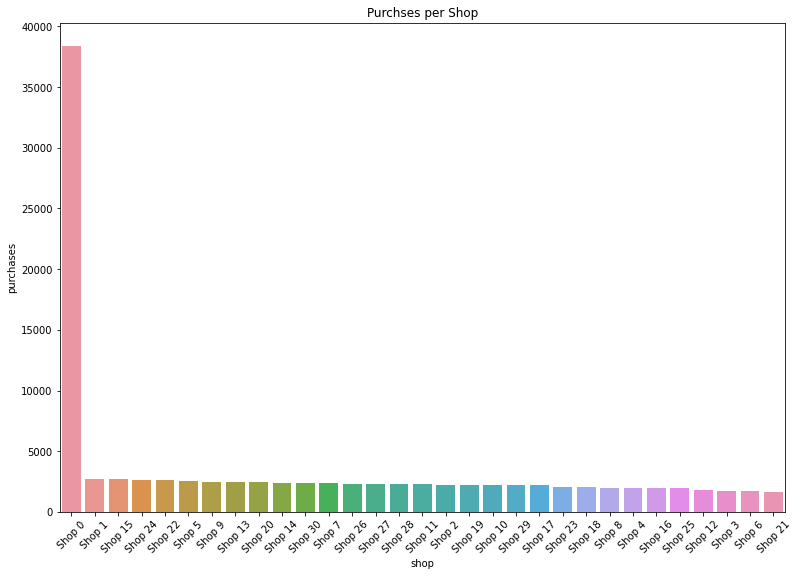

In [18]:
tmp = retail.groupby('shop_id')['pur_id'].count().sort_values(ascending=False).reset_index()
tmp.columns = ['shop','purchases']
plt.figure(figsize=(13,9))
sns.barplot(data=tmp,x='shop',y='purchases')
plt.title('Purchses per Shop')
plt.xticks(rotation=45)
plt.show()

shop 0 is the most popular shop of the chain, by far.

In [19]:
tmp_retail[tmp_retail['shop_id'] == 'Shop 0']

,pur_id,item_id,quantity,pur_date,cus_id,loyalty,shop_id
6,540468,22189,0,2017-01-07 13:55:00,unk,0,Shop 0
7,541424,79321,1,2017-01-17 17:57:00,unk,0,Shop 0
8,538883,22891,0,2016-12-14 15:56:00,unk,0,Shop 0
11,541696,22197,4,2017-01-20 18:08:00,unk,0,Shop 0
16,539744,22300,5,2016-12-21 15:21:00,unk,0,Shop 0
...,...,...,...,...,...,...,...
105325,536982,20719,69,2016-12-03 14:27:00,unk,0,Shop 0
105326,540681,22227,1,2017-01-10 16:25:00,unk,0,Shop 0
105327,538349,22625,0,2016-12-10 14:59:00,unk,0,Shop 0
105329,540154,22134,3,2017-01-05 11:30:00,unk,0,Shop 0


In [20]:
tmp_retail[tmp_retail['shop_id'] == 'Shop 0'].cus_id.value_counts()['unk']

36009

`shop 0`, the shop having the most records, has 94% of its records linked with unknown customer Id's. It also house 99.4% of the data's missing values. By removing all missing records, this shop will be impacted drastically, taking most of the damage. other shops won't be impacted as much.

In [21]:
asd = tmp_retail[tmp_retail['cus_id'] == 'unk'].groupby('shop_id')['pur_id'].count().reset_index()
asd.columns = ['shop_id','n_missing']

In [22]:
shapes0 = []
i = ["Shop 0","Shop 21","Shop 23","Shop 25","Shop 6"]
for b in i:
    shapes0.append(tmp_retail.query('shop_id == @b').shape[0])

In [23]:
pd.DataFrame(data={'shop_id':['Shop 0','Shop 21','Shop 23','Shop 25','Shop 6'],'size':shapes0})

,shop_id,size
0,Shop 0,38389
1,Shop 21,1668
2,Shop 23,2077
3,Shop 25,1935
4,Shop 6,1694


In [24]:
a = asd.merge(pd.DataFrame(data={'shop_id':['Shop 0','Shop 21','Shop 23','Shop 25','Shop 6'],'size':shapes0}),on='shop_id')
a['missing_%'] = a['n_missing'] / a['size']
a

,shop_id,n_missing,size,missing_%
0,Shop 0,36009,38389,0.938003
1,Shop 21,14,1668,0.008393
2,Shop 23,2,2077,0.000963
3,Shop 25,57,1935,0.029457
4,Shop 6,128,1694,0.075561


Only 4 other shops suffer from missing values, but much more gently

Missing data to be removed:

In [25]:
retail = retail.dropna()

In [26]:
# i wanted to retrieve cus_id where possible, using pur_id, but it didnt work out
# this code below needed around 83 free GB to work..

# b = retail[retail['cus_id'] == 'unk']
# for i in b.pur_id:
#     for j in retail[retail['pur_id'] == b].cus_id:
#         if cus_id != 'unk':
#             print(i,j)

In [27]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69125 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   pur_id    69125 non-null  string        
 1   item_id   69125 non-null  string        
 2   quantity  69125 non-null  int64         
 3   pur_date  69125 non-null  datetime64[ns]
 4   cus_id    69125 non-null  float64       
 5   loyalty   69125 non-null  int64         
 6   shop_id   69125 non-null  string        
dtypes: datetime64[ns](1), float64(1), int64(2), string(3)
memory usage: 4.2 MB


## merging `retail` and `product_codes` <a id="mrap"></a>

In [28]:
retail = pd.merge(retail, product_codes, how='left', left_on=['item_id'], right_on=['id'])
retail.drop('id',axis=1,inplace=True)
retail['price'] = retail['quantity'] * retail['price']

## `retail`'s duplicates <a id="rdv"></a>

In [29]:
retail.duplicated().sum()

971

In [30]:
retail.drop_duplicates(inplace=True)
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68154 entries, 0 to 69124
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   pur_id    68154 non-null  string        
 1   item_id   68154 non-null  string        
 2   quantity  68154 non-null  int64         
 3   pur_date  68154 non-null  datetime64[ns]
 4   cus_id    68154 non-null  float64       
 5   loyalty   68154 non-null  int64         
 6   shop_id   68154 non-null  string        
 7   price     68154 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), string(3)
memory usage: 4.7 MB


## Outlier Removal <a id="outrem"></a>

In [31]:
retail.price.quantile(0.01)

-11.049999999999999

In [32]:
retail.price.quantile(0.99)

159.33

All purchases over 160 USD, or refunds of above 11 USD, will be considered outliers and therefore be removed:

In [33]:
retail = retail[(retail['price'] < 160) & (retail['price'] > -11)]
retail

,pur_id,item_id,quantity,pur_date,cus_id,loyalty,shop_id,price
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,Shop 3,4.62
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,Shop 2,0.00
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,Shop 3,5.04
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,Shop 28,0.00
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,Shop 28,0.00
...,...,...,...,...,...,...,...,...
69120,537886,22158,7,2016-12-09 09:49:00,21339.0,0,Shop 13,0.00
69121,540247,21742,0,2017-01-05 15:56:00,21143.0,0,Shop 24,0.00
69122,538068,85048,1,2016-12-09 14:05:00,23657.0,1,Shop 16,6.95
69123,538207,22818,11,2016-12-10 11:33:00,18427.0,0,Shop 29,4.62


## Pre-Processing Summation <a id="ppsu"></a>

Missing customer ID data (1/3 of all raw data) was removed. Outliers removed as well.

By merging, `retail` was enriched with a price column.

Shop 0 must be analysed with respect to it originally consists of 95% missing customer ID data. Or to be removed

# EDA <a id="eda"></a>

In [34]:
retail.cus_id.nunique()

1709

In [35]:
retail.loyalty.value_counts(normalize=True)

0    0.654587
1    0.345413
Name: loyalty, dtype: float64

about 35% of customers are in the loyalty program

In [36]:
retail.groupby('shop_id')['price'].mean().sort_values(ascending=False)

shop_id
Shop 4     15.000330
Shop 25    13.150083
Shop 3     12.590737
Shop 13    12.089453
Shop 6     11.720495
Shop 10    11.695337
Shop 28    11.249589
Shop 12    10.584513
Shop 18    10.453958
Shop 20    10.289575
Shop 16    10.194775
Shop 8     10.155062
Shop 15    10.056918
Shop 0      9.987169
Shop 21     9.937689
Shop 19     9.752214
Shop 30     9.743535
Shop 17     9.721377
Shop 5      9.675107
Shop 23     9.567269
Shop 7      9.455533
Shop 11     9.404947
Shop 2      9.323715
Shop 24     9.179378
Shop 9      9.146909
Shop 14     9.016482
Shop 26     8.914772
Shop 27     8.888734
Shop 22     8.709888
Shop 29     8.622395
Shop 1      7.632921
Name: price, dtype: float64

All shops have positive average price (before outlier removal that wasn't the case)

In [37]:
retail[retail.quantity < 0].shop_id.nunique()

31

In [38]:
retail[retail.price < 0].shop_id.nunique()

31

All shops contain negative quantities - it's so common so it can't be a mistake. It's probably refunds for products customers have returned. All shops contain negative prices as well - that wouldn't had been the case if some shop negative quantities were all associated with a price of 0. Meaning, all shops have cnducted proper refunds.

In [39]:
print(retail.pur_date.min(), '-',retail.pur_date.max())

2016-12-01 08:26:00 - 2017-02-28 17:01:00


Data ranges 3 whole months

In [40]:
retail[retail['quantity'] < -200]

,pur_id,item_id,quantity,pur_date,cus_id,loyalty,shop_id,price
10979,C538847,85232B,-241,2016-12-14 13:27:00,23083.0,1,Shop 12,-0.0
37742,C539329,85123A,-501,2016-12-17 09:37:00,21692.0,0,Shop 27,-0.0


In [41]:
retail[retail['quantity'] > 200].sort_values('price',ascending=False)

,pur_id,item_id,quantity,pur_date,cus_id,loyalty,shop_id,price
912,544097,22335,287,2017-02-16 09:56:00,18134.0,0,Shop 28,157.85
41360,544797,21326,287,2017-02-23 13:43:00,19168.0,0,Shop 5,157.85
41965,538068,22154,431,2016-12-09 14:05:00,23657.0,1,Shop 16,155.16
19192,543168,44235,431,2017-02-04 08:58:00,19373.0,0,Shop 26,155.16
67968,542892,22151,431,2017-02-01 13:28:00,19463.0,0,Shop 5,155.16
...,...,...,...,...,...,...,...,...
39242,540689,22470,1283,2017-01-11 08:43:00,23129.0,1,Shop 15,0.00
40611,538191,22423,271,2016-12-10 10:49:00,20740.0,0,Shop 12,0.00
41591,539109,85123A,499,2016-12-16 11:07:00,21692.0,0,Shop 11,0.00
47856,540478,85099F,299,2017-01-07 14:53:00,21448.0,0,Shop 25,0.00


In [42]:
retail[retail['quantity'] > 200].price.describe()

count    109.000000
mean      74.641193
std       52.051024
min        0.000000
25%       14.370000
50%       95.600000
75%      112.980000
max      157.850000
Name: price, dtype: float64

Altough `quantity` values are pretty extreme, the `price` ends up within bounds and the records seems legit.

In [43]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66804 entries, 0 to 69124
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   pur_id    66804 non-null  string        
 1   item_id   66804 non-null  string        
 2   quantity  66804 non-null  int64         
 3   pur_date  66804 non-null  datetime64[ns]
 4   cus_id    66804 non-null  float64       
 5   loyalty   66804 non-null  int64         
 6   shop_id   66804 non-null  string        
 7   price     66804 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), string(3)
memory usage: 4.6 MB


`cus_id` might be completely full of ints

In [44]:
retail[(retail.cus_id - np.floor(retail.cus_id)) != 0]

,pur_id,item_id,quantity,pur_date,cus_id,loyalty,shop_id,price


In [45]:
retail = retail.astype({'cus_id': 'int64'})

To go easy on the eyes..

In [46]:
cols = ['cus_id','shop_id','pur_id','item_id','pur_date','quantity','price','loyalty']
retail = retail[cols]

## EDA summation <a id="edas"></a>

- 35% of customers are in the loyalty program.
- All shops contain records with negative quantities and prices. Its legit
- Data spreads over 3 whole months: December 2016 to February 2017.

# Plan for The Project <a id="pftp"></a>

The chain's performance should be evaluated, so few things can be done:
- Cohort Analysis - Retention, churn, DAU, average purchase size and LTV calculations
- Identifying leading shops
- Analysing factors characterising customers who are in the loyalty program
- Testing hypotheses - various metrics are expected to be better on the loyal group of customers. That will be checked

# Active Users <a id="acus"></a>

## MAU <a id="mau"></a>

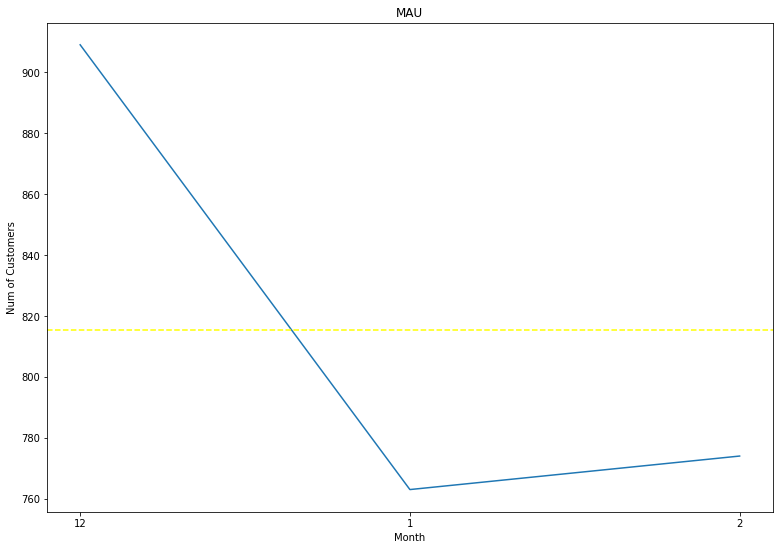

In [47]:
retail['pur_month'] = retail.pur_date.dt.month
mau = retail.groupby('pur_month')['cus_id'].nunique().reset_index()
mau = mau.apply(np.roll, shift=1)
mau = mau.astype({'pur_month': 'string'})
plt.figure(figsize=(13,9))
plt.title('MAU')
plt.xlabel('Month')
plt.ylabel('Num of Customers')
sns.lineplot(data=mau,x='pur_month',y='cus_id')
plt.axhline(y=mau.cus_id.mean(),color='yellow',linestyle='--')
plt.show()

December saw 20% bigger mau. Christmas/Novy-god must account for that.

## WAU <a id="wau"></a>

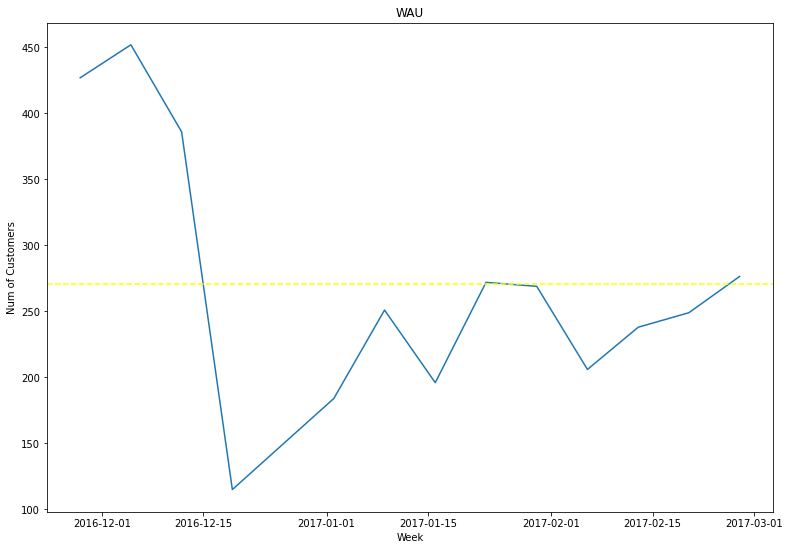

In [48]:
retail['pur_week'] = pd.to_datetime(
    retail['pur_date'], unit='d'
) - pd.to_timedelta(retail['pur_date'].dt.dayofweek, unit='d')
retail.pur_week = retail.pur_week.dt.date
wau = retail.groupby('pur_week')['cus_id'].nunique().reset_index()
wau.loc[0,'cus_id'] = wau.loc[0,'cus_id'] * 7 / 4 # first week only had 4 days
wau.loc[12,'cus_id'] = wau.loc[12,'cus_id'] * 7 / 2 # last week only had 2 days
plt.figure(figsize=(13,9))
plt.title('WAU')
plt.xlabel('Week')
plt.ylabel('Num of Customers')
sns.lineplot(data=wau,x='pur_week',y='cus_id')
plt.axhline(y=wau.cus_id.mean(),color='yellow',linestyle='--')
plt.show()

Looking closer, December high MAU came from the weeks before christmas, while christmas saw a recession in WAU - People equipped themselves in advance with everything they need, so their holiday time will be spent appropriately. The weeks after the holidays were pretty stable WAU-wise

## DAU <a id="dau"></a>

In [49]:
retail['pur_day'] = retail.pur_date.dt.date

In [50]:
dau = retail.groupby('pur_day')['cus_id'].nunique().reset_index()

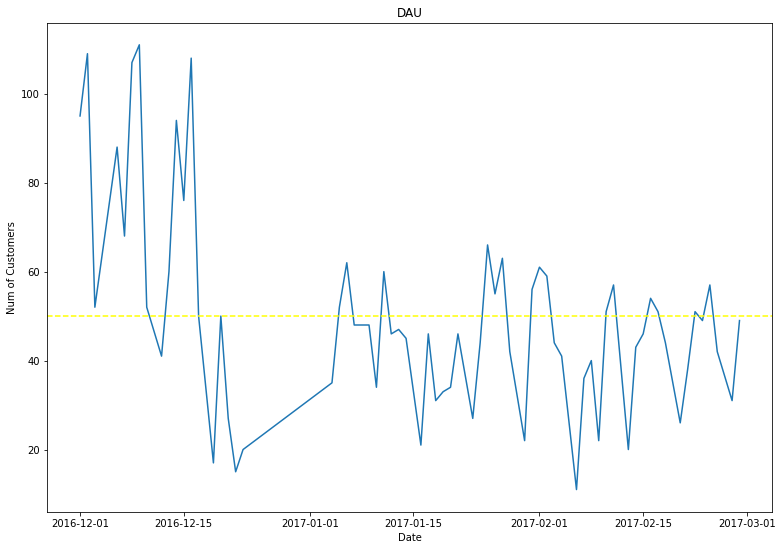

In [51]:
plt.figure(figsize=(13,9))
plt.title('DAU')
plt.xlabel('Date')
plt.ylabel('Num of Customers')
sns.lineplot(data=dau,x='pur_day',y='cus_id')
plt.axhline(y=dau.cus_id.mean(),color='yellow',linestyle='--')
plt.show()

While much more lively, the overall picture closely resembles the WAU one

## DAU/MAU Ratio <a id="dmr"></a>

In [52]:
dau.cus_id.mean() / mau.cus_id.mean()

0.061360684911740654

DAU/MAU ratio of 6%, pretty bad.

# Cohort Analysis <a id="cohana"></a>

In [53]:
first_pur_date = retail.groupby('cus_id')['pur_date'].min()
first_pur_date.name = 'first_pur_date'
retail = retail.join(first_pur_date,on='cus_id')

In [54]:
tmp = retail.groupby('pur_id')['price'].sum()
tmp.name = 'pur_price'
retail = retail.join(tmp,on='pur_id')

In [55]:
retail['pur_week'] = pd.to_datetime(
    retail['pur_date'], unit='d'
) - pd.to_timedelta(retail['pur_date'].dt.dayofweek, unit='d')

retail['first_pur_week'] = pd.to_datetime(
    retail['first_pur_date'], unit='d'
) - pd.to_timedelta(
    retail['first_pur_date'].dt.dayofweek, unit='d'
) 

In [56]:
retail.pur_week = retail.pur_week.dt.strftime("%Y-%m-%d")
retail.first_pur_week = retail.first_pur_week.dt.strftime("%Y-%m-%d")

In [57]:
retail['cohort_lifetime'] = (
    retail['pur_date'] - retail['first_pur_date']
)
retail['cohort_lifetime'] = retail[
    'cohort_lifetime'
] / np.timedelta64(1, 'W')
retail['cohort_lifetime'] = retail['cohort_lifetime'].astype(int)

In [58]:
cohorts = (
    retail.groupby(['first_pur_week', 'cohort_lifetime'])
    .agg({'cus_id': 'nunique','pur_id': 'nunique','pur_price': 'sum'})
    .reset_index()
) 

In [59]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_pur_week', 'cus_id']
]
initial_users_count = initial_users_count.rename(
    columns={'cus_id': 'cohort_users'}
) 
cohorts = cohorts.merge(initial_users_count, on='first_pur_week')

## Retention <a id="reten"></a>

In [60]:
cohorts['retention'] = cohorts['cus_id'] / cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(
    index='first_pur_week',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
)

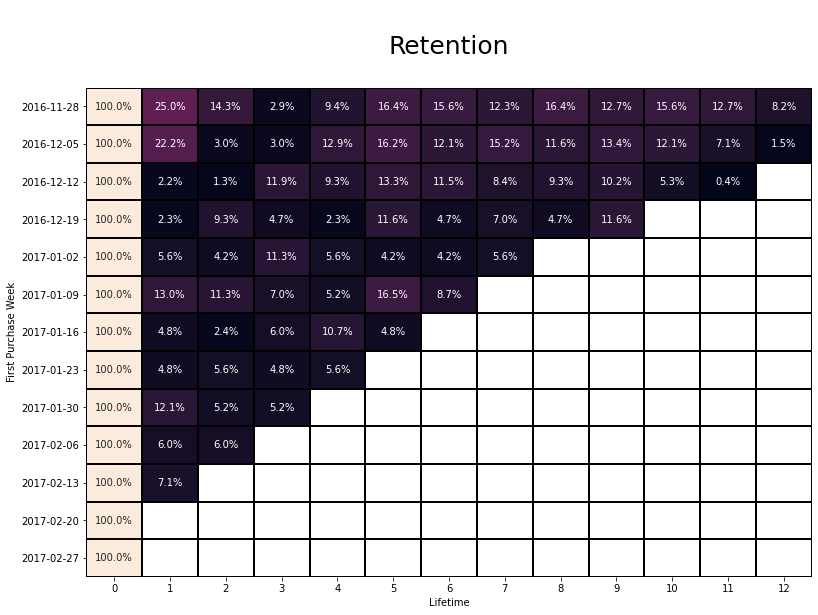

In [61]:
plt.figure(figsize=(13,9))
plt.title('\nRetention\n',fontsize=25)
sns.heatmap(retention_pivot,fmt='.1%',annot=True,linewidths=1,linecolor='black',cbar=False)
plt.xlabel('Lifetime')
plt.ylabel('First Purchase Week')
plt.show()

The first 2 cohorts rise above the others: they both have above 20% of returning customers in the week after first buy, and after 2 weeks of low rates, retention comes back up for both cohorts after christmas to around 15% and stays there until middle February. Other cohorts are not as consistent and anyway present lower retention rates.
It appears customers who had time to evaluate the store quality in a few instances before the holidays came back once holidays were over, as the case for the first 3 cohorts. 
January 9th is a decent cohort as well, tough it remains unknown why. It's consistent so outliers are probably not the reason.

## Churn <a id="churn"></a>

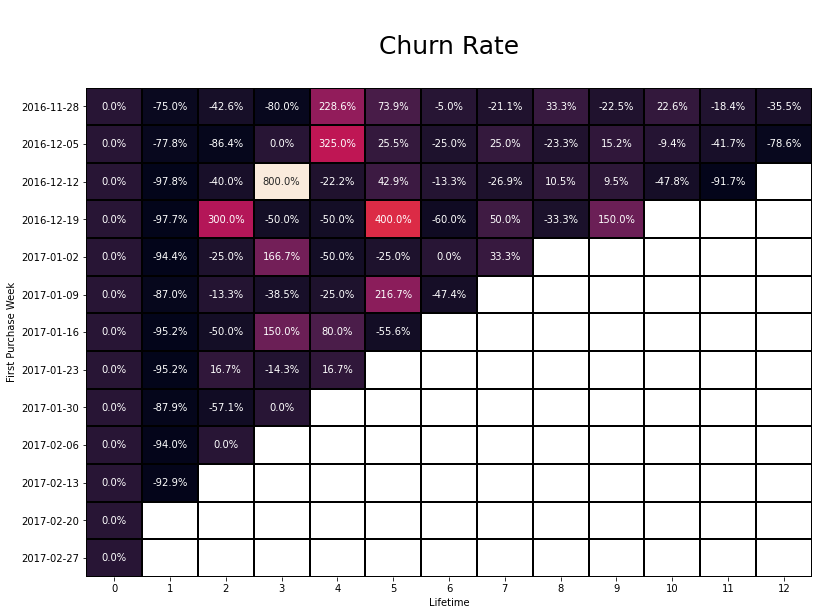

In [62]:
cohorts['churn_rate'] = cohorts.groupby(['first_pur_week'])['cus_id'].pct_change() 
churn_pivot = cohorts.pivot_table(
    index='first_pur_week',
    columns='cohort_lifetime',
    values='churn_rate',
    aggfunc='sum',
)

plt.figure(figsize=(13,9))
plt.title('\nChurn Rate\n',fontsize=25)
sns.heatmap(churn_pivot,fmt='.1%',annot=True,linewidths=1,linecolor='black',cbar=False)
plt.xlabel('Lifetime')
plt.ylabel('First Purchase Week')
plt.show()

After the holidays churn rates jumped for all 3 relevant cohorts. Rest of the jumps might be related to single purchases; No cause is visible for now.

## Average Purchase Size <a id="avprsz"></a>

In [63]:
cohorts['avg_pur'] = cohorts['pur_price'] / cohorts['pur_id']
cohorts['rev_per_cus'] = cohorts['pur_price'] / cohorts['cus_id']

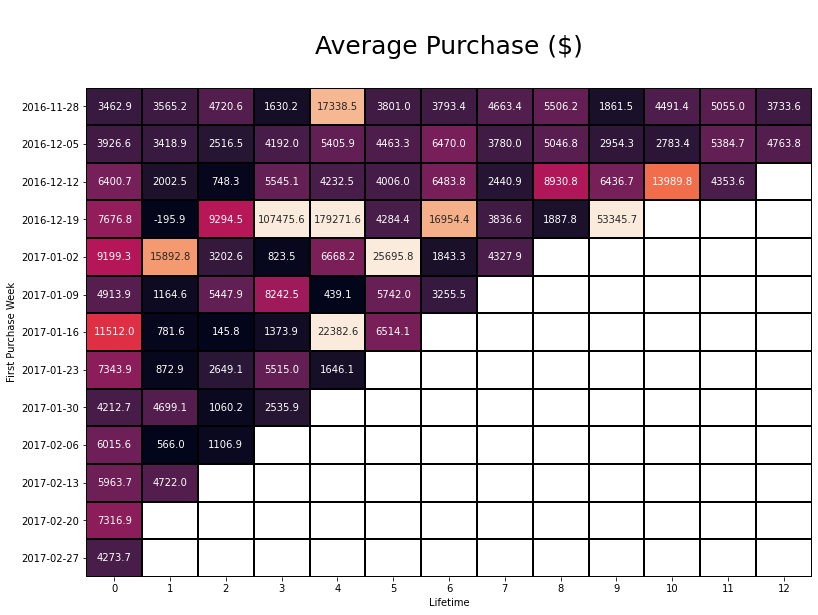

In [64]:
avg_pur_pivot = cohorts.pivot_table(
    index='first_pur_week',
    columns='cohort_lifetime',
    values='avg_pur',
    aggfunc='mean',
)

plt.figure(figsize=(13,9))
plt.title('\nAverage Purchase ($)\n',fontsize=25)
sns.heatmap(avg_pur_pivot,fmt='.1f',annot=True,linewidths=1,linecolor='black',vmin=500,vmax=20000,cbar=False)
plt.xlabel('Lifetime')
plt.ylabel('First Purchase Week')
plt.show()

The 4th cohort has exceptional data. It contains the top 3 weeks in terms of average purchase size.
In all first 4 cohorts, no significant trade took place during the holidays (last week of December).
Later cohorts seem to be less engaged with the chain.
First 2 cohorts have the lowest average purchase in the 0th week, altough overall theyr'e pretty good avergae-purchase-wise.

## Revenue per Customer <a id="revprcs"></a>

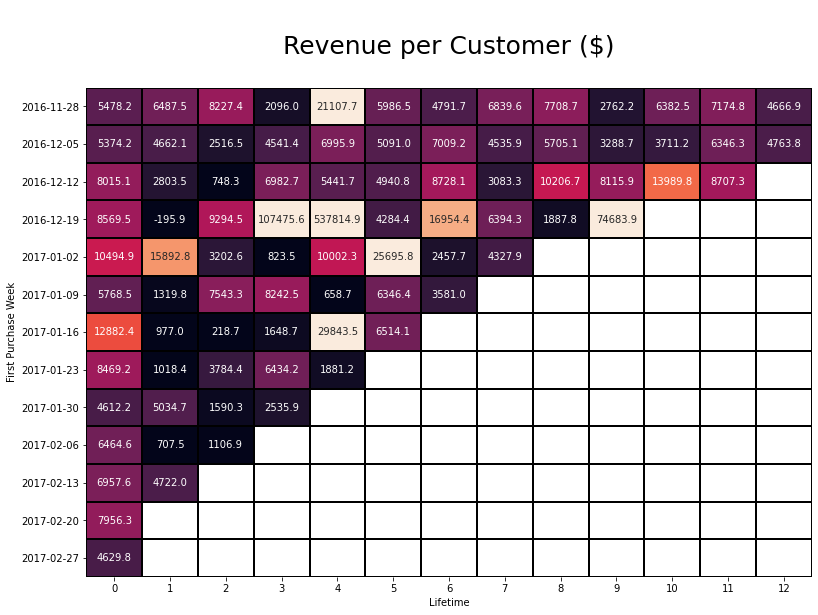

In [65]:
rev_per_cus_pivot = cohorts.pivot_table(
    index='first_pur_week',
    columns='cohort_lifetime',
    values='rev_per_cus',
    aggfunc='mean',
)

plt.figure(figsize=(13,9))
plt.title('\nRevenue per Customer ($)\n',fontsize=25)
sns.heatmap(rev_per_cus_pivot,fmt='.1f',annot=True,linewidths=1,linecolor='black',vmin=1000,vmax=20000,cbar=False)
plt.xlabel('Lifetime')
plt.ylabel('First Purchase Week')
plt.show()

Very similar to the latter heatmap. First 4 cohorts, that started before the holidays, have the upper hand.

## Cohort Analysis Summation <a id="cohanasum"></a>

Customers who got to know the chain before the holidays turned out to be much better customers in the months following.
Generally tough, for the majority of cohorts, the 0th is the most meaningful sales-wise.

# Leading Shops <a id="leadshops"></a>

## Revenue per Customer <a id="rvprcr"></a>

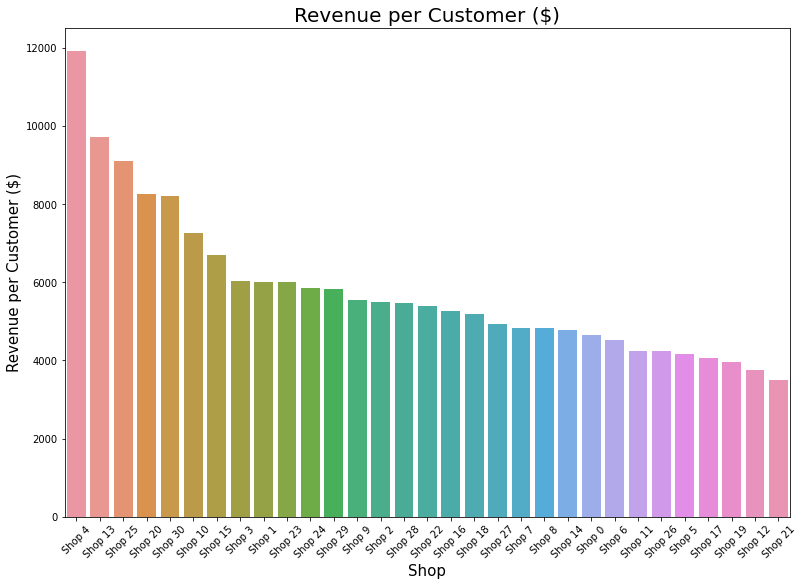

In [66]:
shops = retail.groupby('shop_id').agg({'cus_id':'nunique','pur_id':'nunique','pur_price':'sum'})
shops['avg_purchase'] = shops['pur_price'] / shops['pur_id']
shops['rev_per_cus'] = shops['pur_price'] / shops['cus_id']
shops['purs_per_cus'] = shops['pur_id'] / shops['cus_id']
shops = shops.sort_values('rev_per_cus',ascending=False).reset_index()

plt.figure(figsize=(13,9))
sns.barplot(data=shops,x='shop_id',y='rev_per_cus')
plt.title('Revenue per Customer ($)',fontsize=20)
plt.xticks(rotation=45)
plt.xlabel('Shop',fontsize=15)
plt.ylabel('Revenue per Customer ($)',fontsize=15)
plt.show()

Shop 4 at top, with twice the revenue per customer compare with the majority of shops.

## Average Purchase <a id="avgprch"></a>

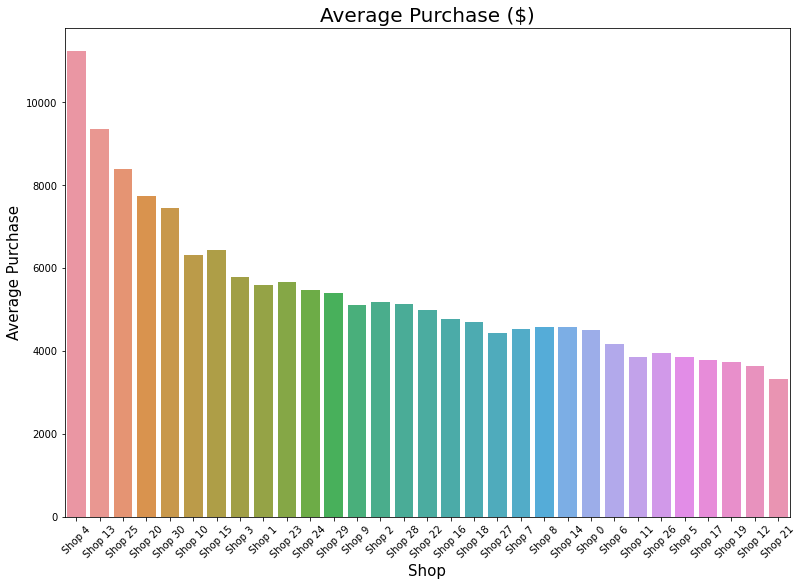

In [67]:
plt.figure(figsize=(13,9))
sns.barplot(data=shops,x='shop_id',y='avg_purchase')
plt.title('Average Purchase ($)',fontsize=20)
plt.xticks(rotation=45)
plt.xlabel('Shop',fontsize=15)
plt.ylabel('Average Purchase',fontsize=15)
plt.show()

Shops rank almost the same as before

## Number of Customers <a id="nofcust"></a>

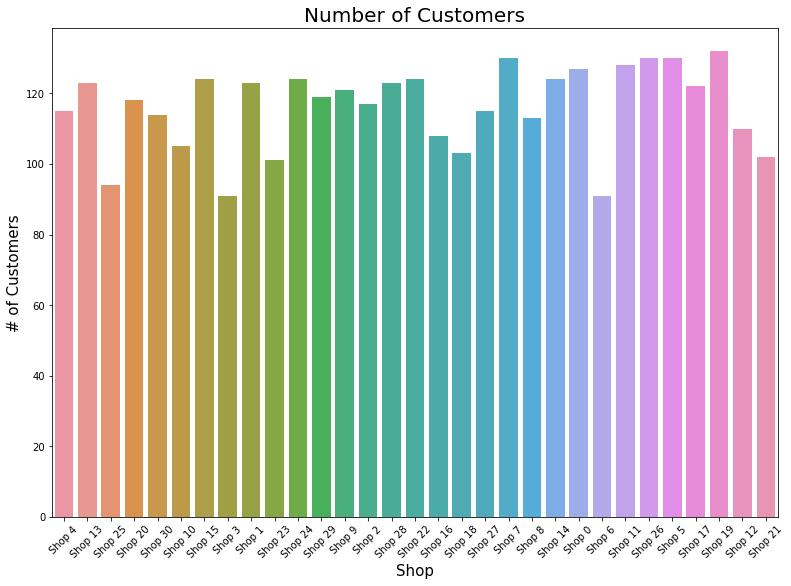

In [68]:
plt.figure(figsize=(13,9))
sns.barplot(data=shops,x='shop_id',y='cus_id')
plt.title('Number of Customers',fontsize=20)
plt.xticks(rotation=45)
plt.xlabel('Shop',fontsize=15)
plt.ylabel('# of Customers',fontsize=15)
plt.show()

Around 100 customers per shop. No drastic differences between any of the shops

## Purchases per Customer <a id="prcprcstm"></a>

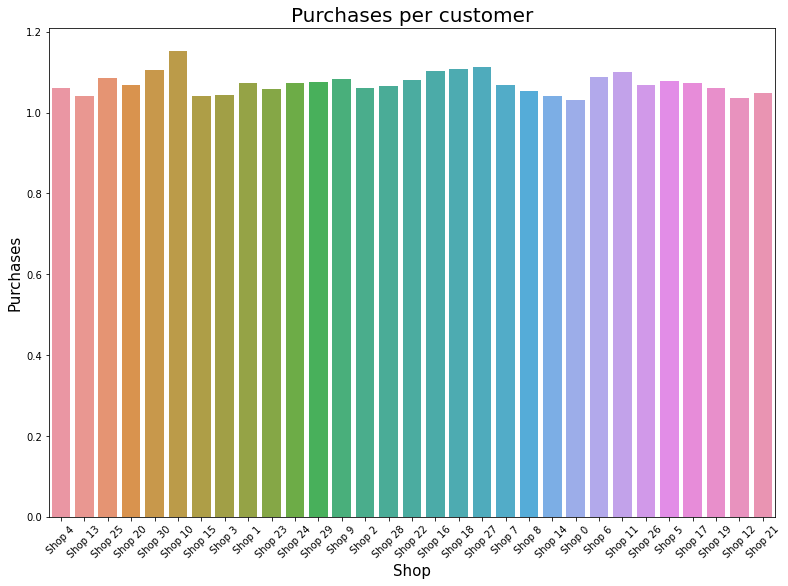

In [69]:
plt.figure(figsize=(13,9))
sns.barplot(data=shops,x='shop_id',y='purs_per_cus')
plt.title('Purchases per customer',fontsize=20)
plt.xticks(rotation=45)
plt.xlabel('Shop',fontsize=15)
plt.ylabel('Purchases',fontsize=15)
plt.show()

In average, in every shop, every customer had one purchase

## Leading Shops Summation <a id="leadshopsum"></a>

Shops 4, 13 and 25 have the best numbers, therefore theyr'e the leading shops.

# Characterising Loyal Customers <a id='clc'></a>

Ideally, machine learning could be incorporated to uncover the factors characterising loyal customers. However, the raw data mostly consist of ID's of all sorts, with `price` and `loyalty` being the only relevant columns who aren't some sort of ID. So, all meaningful knowledge is to be extracted using aggregation by all sorts of ID's, and machine learning wouldn't help in such a case.

In [70]:
unloyal_retail = retail[retail['loyalty'] == 0]
loyal_retail = retail[retail['loyalty'] == 1]

## Purchases per Customer <a id='prchprcs'></a>

In [71]:
loyal_retail.groupby('cus_id')['pur_id'].nunique().mean()

2.1982456140350877

In [72]:
unloyal_retail.groupby('cus_id')['pur_id'].nunique().mean()

2.2879719051799823

## Number of Shops Visited <a id='nmbsv'></a>

In [73]:
unloyal_retail.groupby('cus_id')['shop_id'].nunique().value_counts(normalize=True)

1     0.566286
2     0.205443
3     0.088674
4     0.049166
5     0.030729
6     0.017559
7     0.012291
8     0.007024
9     0.006146
12    0.004390
10    0.003512
11    0.002634
16    0.002634
14    0.000878
20    0.000878
21    0.000878
23    0.000878
Name: shop_id, dtype: float64

In [74]:
loyal_retail.groupby('cus_id')['shop_id'].nunique().value_counts(normalize=True)

1     0.536842
2     0.201754
3     0.126316
4     0.057895
5     0.026316
6     0.026316
7     0.008772
8     0.008772
9     0.001754
11    0.001754
18    0.001754
20    0.001754
Name: shop_id, dtype: float64

About the same top 5, so no difference in number of shops visited between loyal to unloyal customers

## Items per Purchase <a id='itpp'></a>

In [75]:
unloyal_retail.groupby('pur_id')['item_id'].nunique().value_counts(normalize=True).head()

1    0.155411
2    0.064850
3    0.043745
5    0.036071
4    0.034152
Name: item_id, dtype: float64

In [76]:
loyal_retail.groupby('pur_id')['item_id'].nunique().value_counts(normalize=True).head()

1    0.138069
2    0.062251
3    0.035914
9    0.035116
5    0.034318
Name: item_id, dtype: float64

Same top 3. No significant difference between number of items in a purchase between loyal to unloyal customers.

## Price per Purchase <a id='prprpr'></a>

In [77]:
loyal_retail.groupby(['cus_id','pur_id'])['price'].sum().describe()

count    1253.000000
mean      151.676081
std       217.086199
min       -42.060000
25%        32.640000
50%        93.840000
75%       199.150000
max      2553.910000
Name: price, dtype: float64

In [78]:
unloyal_retail.groupby(['cus_id','pur_id'])['price'].sum().describe()

count    2606.000000
mean      185.497736
std       303.369118
min       -82.200000
25%        24.290000
50%       114.585000
75%       228.152500
max      5093.450000
Name: price, dtype: float64

Unloyal customers pay 35 dollars more per purchase. On the other hand, they don't pay 20 dollars per month for the loyalty program membership.

## Loyal Characterisation Summation <a id='lychsum'></a>

For now, no clear method of characterising loyal customers is at hand.

# Hypotheses Testing <a id='hyptes'></a>

Number of hypotheses to be tested, regarding diffrences between the loyal to unloyal customers:
- Whether purchase size is the same between the groups
- Whether number of purchases per customer is the same between the groups

## Purchase Size <a id='purchsz'></a>

**Null Hypothesis:**
* Mean purchase size is equal between the loyal/unloyal customers

**Alternative Hypothesis:**
* Mean purchase size differs between the loyal/unloyal customers

In [79]:
tmpa = loyal_retail.groupby(['cus_id','pur_id'])['price'].sum().reset_index()['price']
tmpb = unloyal_retail.groupby(['cus_id','pur_id'])['price'].sum().reset_index()['price']

In [80]:
alpha = 0.05 / 2 # 2 tests are conducted, bonferroni

results = st.ttest_ind(tmpa, tmpb)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

p-value:  0.00041252390669812504
We reject the null hypothesis


Thus, the difference in average purchase size is significant. It's not surprising, as average purchase size for loyal customers is 152 dollar, while for unloyal customers its 185 dollar - more than 20% difference.

## Purchases per Customer <a id='hypprcst'></a>

**Null Hypothesis:**
* Mean purchases per customer is equal between the loyal/unloyal customers

**Alternative Hypothesis:**
* Mean purchases per customer differs between the loyal/unloyal customers

In [81]:
tmpa = loyal_retail.groupby('cus_id')['pur_id'].nunique()
tmpb = unloyal_retail.groupby('cus_id')['pur_id'].nunique()

In [82]:
alpha = 0.05 / 2 # 2 tests are conducted, bonferroni

results = st.ttest_ind(tmpa, tmpb)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis") 

p-value:  0.5362198795633994
We can't reject the null hypothesis


The difference between the means is not significant. Again, no surprise. The mean for loyal customers is 2.2, and for the unloyals its 2.3, pretty close.

# Conclusion <a id='conc'></a>

- Highest rates of active users achieved during the 2 weeks right before the holidays
- Customers who made a purchase in the chain before the holidays somehow had better engagement in the months to come, relative to new customers. As if that first purchase made their holiday great, and made them remember the chain fondly.
- Retention rates are around 15% at best. The average customer makes only 2 purchases in the chain
- Shops 4, 13 and 25 have the best metrics.
- Loyal customers pay less per purchase, and buy as often as their non-loyal colleagues. They save around 3 dollars a month by being in the loyalty program.

# Presentation<a id='present'></a>

https://drive.google.com/file/d/1GgH3ZqOP48qvvkTd_OiHFjKXUUGGLbZZ/view?usp=sharing

# Dashboard <a id='dash'></a>

https://public.tableau.com/views/Retail_16744275111360/RetailDash?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link